# SBRC2022

<div align="justify"> O objetivo deste notebook é apresentar exemplos de utilização de modelos de Aprendizado de Máquina aplicado aos problemas de redes de computadores. Iremos tratar especificamente de Detecção de DDoS. Para isto iremos utilizar a linguagem Python com as bibliotecas NumPy, Pandas e Scikit learn. </div>

Esse Notebook aboradará os seguintes passos:
    <ul>
    <li>Preparação dos Dados</li>
    <li>Definição das Classes</li>
    <li>Classificação com Modelos AM</li>
    <li>Conclusão</li>



## Conectar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls 'drive/MyDrive/Doutorado/Minicurso'

'Classifications_Models-Rolling Windows.ipynb'
 dataset_classificacao.csv
 dataset_sdn.csv
 DDoS_Detection.ipynb
 filtered_dataset_classificacao.csv
 modelo.mlp
'Traffic Classification.ipynb'
 Untitled0.ipynb


In [ ]:
path_dataset = 'drive/MyDrive/Doutorado/Minicurso/dataset_sdn.csv'
path_dataset_filtered = 'drive/MyDrive/Doutorado/Minicurso/filtered_dataset_sdn.csv'
path_model_ddos = 'drive/MyDrive/Doutorado/Minicurso/modelo_ddos.mlp'

## Importar Bibliotecas

In [ ]:
#libraries for data manipulation
import numpy as np
import pandas as pd

#Models for Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


#libraries for selecting features and parameters
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#libraries for validation
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn import preprocessing

#libraries for graphics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import time


## Preparação dos Dados

### Carregar Dataset

In [ ]:
df = pd.read_csv(path_dataset, sep=',')

In [ ]:
df

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


### Visualizar os Dados

In [ ]:
#view of columns 
df.columns

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
       'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [ ]:
df.isna().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.label.value_counts()

0    63335
1    40504
Name: label, dtype: int64

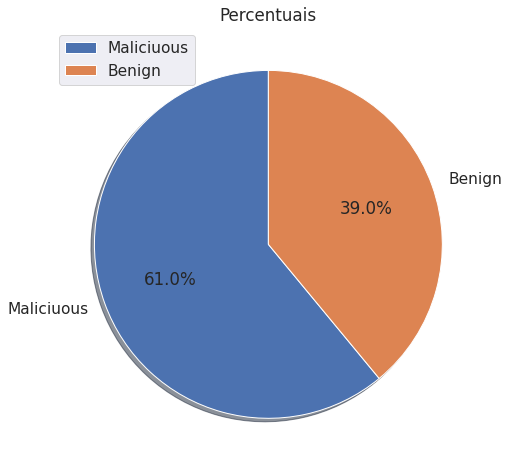

In [ ]:
labels = ["Maliciuous",'Benign']
sizes = [dict(df.label.value_counts())[0], dict(df.label.value_counts())[1]]
plt.figure(figsize = (13,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend(["Maliciuous", "Benign"])
plt.title('Percentuais')
plt.show()

## Definição das Classes

In [ ]:
x = df.drop(['dt','src','dst','label'], axis=1)
y = df.label

In [ ]:
x = pd.get_dummies(x)

In [ ]:
x

,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,...,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,Protocol_ICMP,Protocol_TCP,Protocol_UDP
0,1,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,...,0,3,143928631,3917,0,0.0,0.0,0,0,1
1,1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,...,0,4,3842,3520,0,0.0,0.0,0,0,1
2,1,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,...,0,1,3795,1242,0,0.0,0.0,0,0,1
3,1,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,...,0,2,3688,1492,0,0.0,0.0,0,0,1
4,1,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,...,0,3,3413,3665,0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,3,79,7742,81,842000000,8.184200e+10,5,10,29,2842,...,0,1,15209,12720,1,1.0,2.0,1,0,0
104341,3,79,7742,81,842000000,8.184200e+10,5,10,29,2842,...,0,3,15099,14693,1,1.0,2.0,1,0,0
104342,3,31,3038,31,805000000,3.180500e+10,5,10,30,2940,...,0,2,3409,3731,0,0.0,0.0,1,0,0
104343,3,31,3038,31,805000000,3.180500e+10,5,10,30,2940,...,0,1,15209,12720,1,1.0,2.0,1,0,0


In [ ]:
x = preprocessing.StandardScaler().fit(x).transform(x)

In [ ]:
x

array([[-1.64314171, -0.14363305,  0.21082642, ..., -0.81298564,
        -0.62899063,  1.46247627],
       [-1.64314171,  1.41397731,  1.98419058, ..., -0.81298564,
        -0.62899063,  1.46247627],
       [-1.64314171,  0.72129199,  1.19555733, ..., -0.81298564,
        -0.62899063,  1.46247627],
       ...,
       [-0.62080915, -1.0132449 , -0.7798561 , ...,  1.23003403,
        -0.62899063, -0.68377178],
       [-0.62080915, -1.0132449 , -0.7798561 , ...,  1.23003403,
        -0.62899063, -0.68377178],
       [-0.62080915, -1.0132449 , -0.7798561 , ...,  1.23003403,
        -0.62899063, -0.68377178]])

### Criar conjunto Alvo

In [ ]:
y

0         0
1         0
2         0
3         0
4         0
         ..
104340    0
104341    0
104342    0
104343    0
104344    0
Name: label, Length: 103839, dtype: int64

In [ ]:
y.describe()

count    103839.000000
mean          0.390065
std           0.487767
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3)

###  Grid Search Parameters

In [ ]:
#parameters for KNN - number of neighbors
lista_k = [1,3,5,10,20]
parametros_knn = dict(n_neighbors=lista_k)

#parameteres for RF and AdaBoost - number of trees
lista_t = [10,20,50,100,200,400]
parametros_rf = dict(n_estimators=lista_t)

#parameters for SVM
lista_c = [1,2,4,8,16,32,64]
parametros_rbf = dict(C=lista_c)

print(parametros_knn)
print(parametros_rf)
print(parametros_rbf)

{'n_neighbors': [1, 3, 5, 10, 20]}
{'n_estimators': [10, 20, 50, 100, 200, 400]}
{'C': [1, 2, 4, 8, 16, 32, 64]}


## Classificação com Modelos AM

### KNN

In [ ]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,parametros_knn,cv=10)

In [ ]:
inicio_grid_knn = time.time()
grid.fit(x_treino,y_treino)
tempo_grid_knn = time.time()- inicio_grid_knn

In [ ]:
grid.best_params_

{'n_neighbors': 1}

In [ ]:
grid.best_score_

0.9758553012684272

#### KNN Performance

In [ ]:
inicio_predicao_knn = time.time()
prev_knn = grid.predict(x_teste)
tempo_predicao_knn = time.time() - inicio_predicao_knn

In [ ]:
prev_knn

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
acc_res = metrics.accuracy_score(y_teste,prev_knn)
prec = metrics.precision_score(y_teste,prev_knn,average='weighted')
rec = metrics.recall_score(y_teste,prev_knn,average='weighted')
f1s = metrics.f1_score(y_teste,prev_knn,average='weighted')

In [ ]:
print(f'Precision: {prec:.2f}')
print(f'Recall:    {rec:.2f}')
print(f'F-1 Score: {f1s:.2f}')
print(f'Accuracy:  {acc_res:.2f}')
print(" ")
print(f'Tempo Grid:  {tempo_grid_knn:.2f}')
print(f'Tempo Execução:  {tempo_predicao_knn:.2f}')

Precision: 0.98
Recall:    0.98
F-1 Score: 0.98
Accuracy:  0.98
 
Tempo Grid:  351.46
Tempo Execução:  20.38


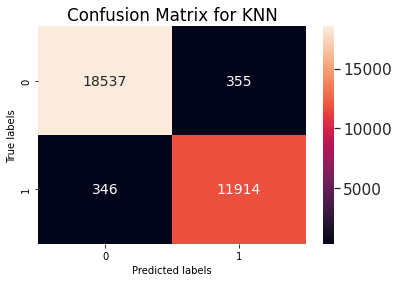

In [ ]:
ax= plt.subplot()
array = confusion_matrix(y_teste, prev_knn)      
df_cm = pd.DataFrame(array, range(2),range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, ax = ax,fmt="d")# font size

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for KNN'); 
#ax.xaxis.set_ticklabels(['Não Popular', 'Popular']); ax.yaxis.set_ticklabels(['Não Popular', 'Popular']);

### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=1986,
                           criterion='gini',
                           max_depth=10,
                           n_estimators=50,
                           n_jobs=-1)

grid = GridSearchCV(rf,parametros_rf,cv=10)

In [ ]:
inicio_grid_rf = time.time()
rf.fit(x_treino,y_treino)
tempo_grid_rf = time.time()- inicio_grid_rf

#### Random Forest - Performance

In [ ]:
inicio_predicao_rf = time.time()
prev_rf = rf.predict(x_teste)
tempo_predicao_rf = time.time() - inicio_predicao_rf

In [ ]:
acc_res = metrics.accuracy_score(y_teste,prev_rf)
prec = metrics.precision_score(y_teste,prev_rf,average='weighted')
rec = metrics.recall_score(y_teste,prev_rf,average='weighted')
f1s = metrics.f1_score(y_teste,prev_rf,average='weighted')

In [ ]:
print(f'Precision: {prec:.4f}')
print(f'Recall:    {rec:.4f}')
print(f'F-1 Score: {f1s:.4f}')
print(f'Accuracy:  {acc_res:.4f}')
print(" ")
print(f'Tempo Grid:  {tempo_grid_rf:.4f}')
print(f'Tempo Execução:  {tempo_predicao_rf:.4f}')

Precision: 0.9957
Recall:    0.9957
F-1 Score: 0.9957
Accuracy:  0.9957
 
Tempo Grid:  2.7395
Tempo Execução:  0.1087


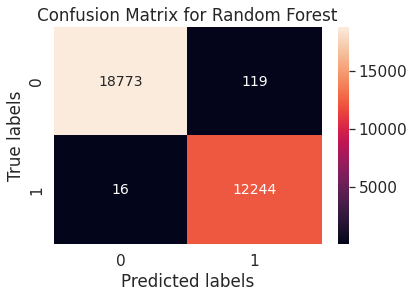

In [ ]:
ax= plt.subplot()
array = confusion_matrix(y_teste, prev_rf)      
df_cm = pd.DataFrame(array, range(2),range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, ax = ax,fmt="d")# font size

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Random Forest'); 

### Redes Neurais

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

#### Construindo a Rede

In [ ]:
mlp = MLPClassifier(random_state=1, max_iter=300,hidden_layer_sizes=(10,50,100,300,300,100,50,10),activation = 'relu', batch_size= 1000, solver='adam')

In [ ]:
inicio_treinamento_mlp = time.time()
mlp.fit(x_treino, y_treino)
tempo_treinamento_mlp = time.time() - inicio_treinamento_mlp

In [ ]:
inicio_predicao_mlp = time.time()
prev_mlp =  mlp.predict(x_teste)
tempo_predicao_mlp = time.time() - inicio_predicao_mlp

#### Performance


In [ ]:
acc_res = metrics.accuracy_score(y_teste,prev_mlp)
prec = metrics.precision_score(y_teste,prev_mlp,average='weighted')
rec = metrics.recall_score(y_teste,prev_mlp,average='weighted')
f1s = metrics.f1_score(y_teste,prev_mlp,average='weighted')

In [ ]:
print(f'Precision: {prec:.4f}')
print(f'Recall:    {rec:.4f}')
print(f'F-1 Score: {f1s:.4f}')
print(f'Accuracy:  {acc_res:.4f}')
print(" ")
print(f'Tempo Grid:  {tempo_treinamento_mlp:.4f}')
print(f'Tempo Execução:  {tempo_predicao_mlp:.4f}')

Precision: 0.9916
Recall:    0.9915
F-1 Score: 0.9915
Accuracy:  0.9915
 
Tempo Grid:  381.8135
Tempo Execução:  0.6140


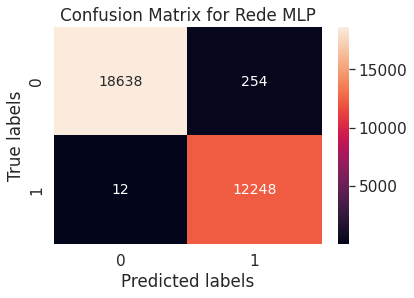

In [ ]:
ax= plt.subplot()
array = confusion_matrix(y_teste, prev_mlp)      
df_cm = pd.DataFrame(array, range(2),range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, ax = ax,fmt="d")# font size

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Rede MLP');

# Persistência


In [ ]:
import joblib

In [ ]:
joblib.dump(prev_mlp,path_model_mlp)

['drive/MyDrive/Doutorado/Minicurso/modelo.mlp']

In [ ]:
model = joblib.load('rf_model')
resultados = model.predict(x_teste)

In [ ]:
print(resultados)

[15 15  7 ...  7  8  6]


# Conclusão

<div align="justify">Foi realizada a detecção de DDoS utilizando modelos de AM para exemplificação do minicurso apresentado no SRBC 2022. </div>


# Referências

<div>[1] https://www.kaggle.com/code/aikenkazin/ddos-attack-detection-classification/data.</div>